## Day3

In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from utils import reset_seed, display_compare
from time import time
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Reshape, Lambda, Layer, Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.nn import leaky_relu

In [2]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)

# Definition of the model

In [3]:
def sampling_fn(inputs):
    mean, log_var = inputs
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(log_var / 2) + mean

In [4]:
class CVEncoder(Layer):
    """Variational Encoder"""
    def __init__(self, latent_dim, filters):
        super().__init__()
        self.latent_dim = latent_dim
        self.filters = filters
        
        self.input_layer = Reshape((28, 28, 1), input_shape=(28, 28))
        self.conv1  = Conv2D(filters, 3, padding='same', activation=leaky_relu)
        self.conv2  = Conv2D(2 * filters, 3, padding='same', activation=leaky_relu)
        self.flatten = Flatten()
        self.lin_mean = Dense(latent_dim)
        self.lin_var  = Dense(latent_dim)
        self.sampling = Lambda(sampling_fn, name="sampling_layer")
    
    def call(self, x):
        z = self.input_layer(x)
        z = self.conv1(z)
        z = self.conv2(z)
        z = self.flatten(z)
        mean    = self.lin_mean(z)
        log_var = self.lin_var(z)
        codings = self.sampling([mean, log_var])
        return codings, mean, log_var
        
class CVDecoder(Layer):
    """Variational Decoder"""
    def __init__(self, filters):
        super().__init__()
        self.filters = filters
        
        self.input_layer = Dense(2 * filters * 28 * 28)
        self.reshape = Reshape((28, 28, 2 * filters))
        self.hidden1 = Conv2DTranspose(4 * filters, 3, padding='same', activation=leaky_relu)
        self.hidden2 = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')
        self.output_layer = Reshape((28, 28))
    
    def call(self, z):
        z = self.input_layer(z)
        z = self.reshape(z)
        z = self.hidden1(z)
        z = self.hidden2(z)
        reconstruction  = self.output_layer(z)
        return reconstruction
    
class CVAE(Model):
    """Variational autoencoder."""
    def __init__(self, latent_dim, filters=4, kl_factor=0.0015):
        super().__init__()
        self.latent_dim = latent_dim
        self.filters = filters
        self.kl_factor  = kl_factor
        self.encoder = CVEncoder(latent_dim, filters)
        self.decoder = CVDecoder(filters)
        
    def call(self, x):
        # Encoder
        z, mean, log_var = self.encoder(x)
        # Decoder
        reconstruction   = self.decoder(z)
        
        # Add KL Loss
        kl_loss = -0.5*tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=-1)
        self.add_loss(self.kl_factor * tf.reduce_mean(kl_loss))
        return reconstruction

### bidimensional latent space

In [4]:
#SINGLE GPU
model = CVAE(2)
model.compile(loss="binary_crossentropy", optimizer="rmsprop")
model.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))

Epoch 1/25
352/352 [==============================] - 2s 6ms/step - loss: 0.4055 - val_loss: 0.3782
Epoch 2/25
352/352 [==============================] - 2s 6ms/step - loss: 0.3738 - val_loss: 0.3689
Epoch 3/25
352/352 [==============================] - 2s 6ms/step - loss: 0.3651 - val_loss: 0.3620
Epoch 4/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3600 - val_loss: 0.3593
Epoch 5/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3574 - val_loss: 0.3558
Epoch 6/25
352/352 [==============================] - 2s 6ms/step - loss: 0.3551 - val_loss: 0.3553
Epoch 7/25
352/352 [==============================] - 2s 6ms/step - loss: 0.3533 - val_loss: 0.3531
Epoch 8/25
352/352 [==============================] - 2s 6ms/step - loss: 0.3519 - val_loss: 0.3542
Epoch 9/25
352/352 [==============================] - 2s 6ms/step - loss: 0.3508 - val_loss: 0.3502
Epoch 10/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3499 - val_loss: 0.3525

In [6]:
reset_seed()
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = CVAE(2)
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
model.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
352/352 [==============================] - ETA: 0s - loss: 0.4040INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/t

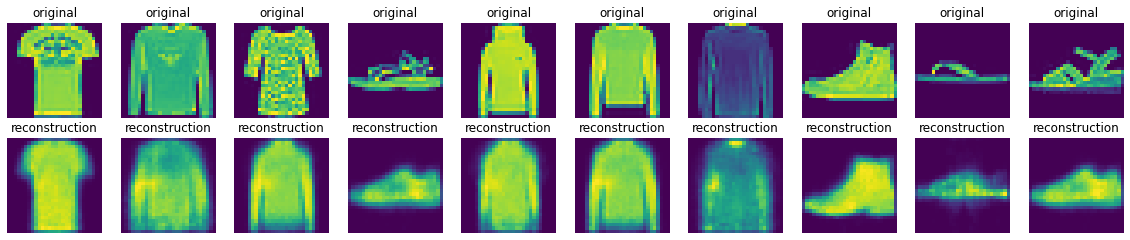

In [7]:
history = model.predict(x_val)
display_compare(x_val, history, names=["original", "reconstruction"])

In [ ]:
def get_curve(n_points=50, x_scale=1.5, y_scale=4):
    t_ = np.linspace(0,2*np.pi,n_points)
    curve_x = x_scale * np.sin(t_)
    curve_y = y_scale * np.sin(t_) * np.cos(t_)
    curve = np.vstack([curve_x, curve_y]).transpose()
    return np.float32(curve)

curve     = get_curve()
decoder   = model.layers[1]
codings, *_ = model.encoder(x_val)
curve_rec = decoder(curve)

start =time()
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.05, 0.05, .55, 0.85])
ax2 = fig.add_axes([.6, 0.25, 0.3, 0.45])
ax2.axis('off')
ax.set_title('Latent space')
title = ax2.set_title('Decoder Output')
ax.plot(*np.hsplit(curve,2), ls='--')

ax.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.4)
point, = ax.plot(*curve[0], 'bo')
img = ax2.imshow(curve_rec[0])

def update(i):
    point.set_data(*curve[i])
    img = ax2.imshow(curve_rec[i])
    return point, img

anim = FuncAnimation(fig, update, frames=np.arange(len(curve)), interval=200)
anim.save('CVAE.gif', writer='imagemagick')

Image(filename="CVAE.gif")

### 50-dimensional latent space

we can rule out that the true distribution is a multivariate gaussian, where increasing the number of latent space dimensions makes possible to differentiate similar classes

In [11]:
reset_seed()
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model50 = CVAE(50)
    model50.compile(loss="binary_crossentropy", optimizer="rmsprop")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [12]:
model50.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
352/352 [==============================] - 4s 11ms/step - loss: 0.3711 - val_loss: 0.3425
Epoch 2/25
352/352 [==============================] - 2s 7ms/step - loss: 0.3322 - val_loss: 0.3284
Epoch 3/25
352/352 [==============================] - 2s 7ms/step -

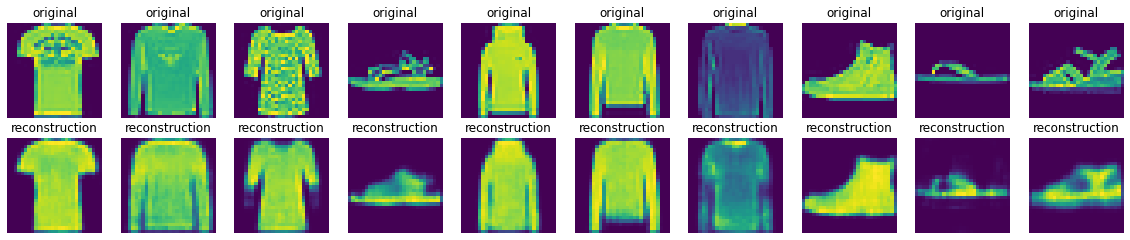

In [6]:
history50 = model50.predict(x_val)
display_compare(x_val, history50, names=["original", "reconstruction"])

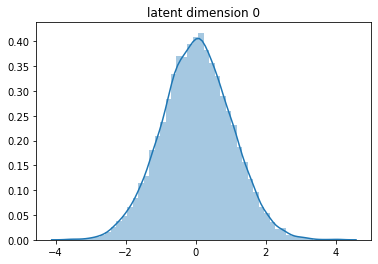

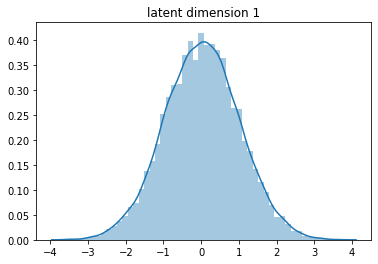

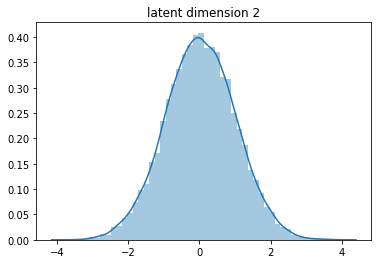

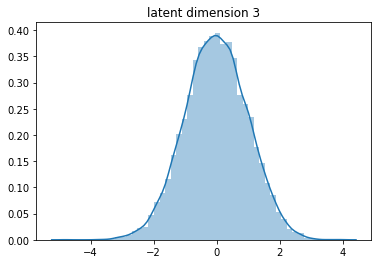

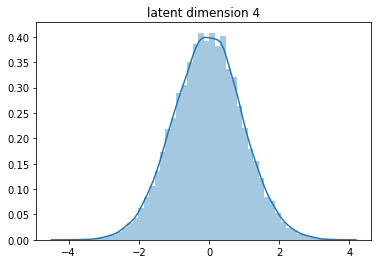

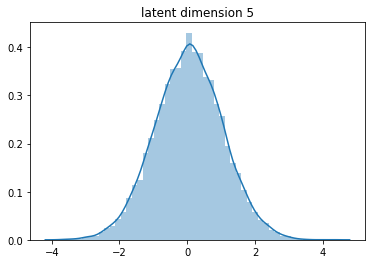

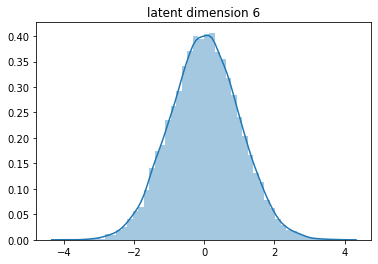

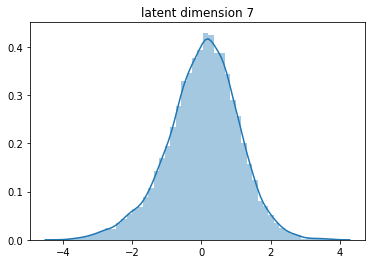

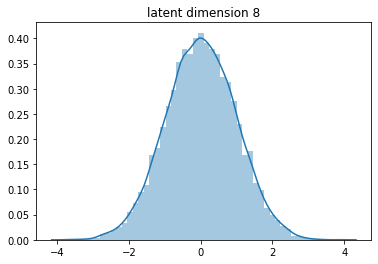

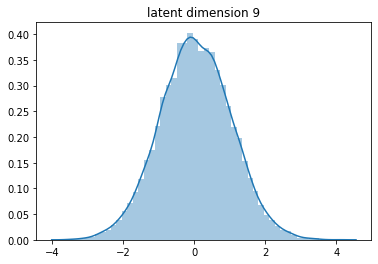

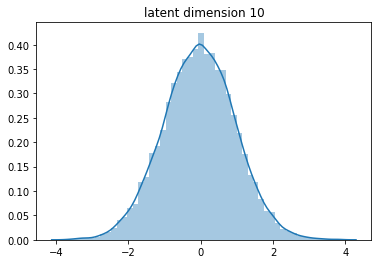

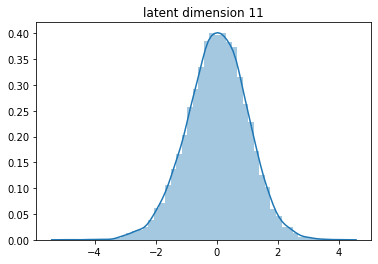

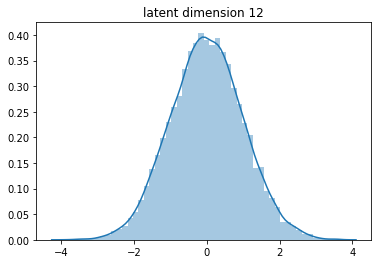

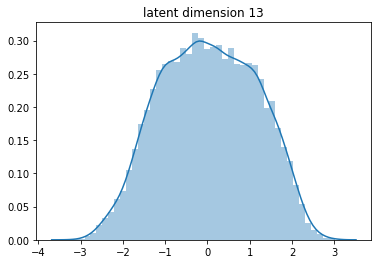

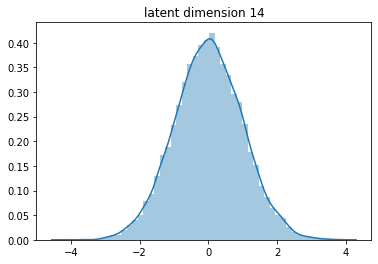

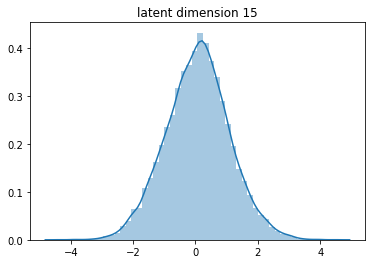

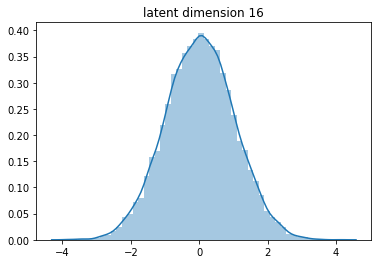

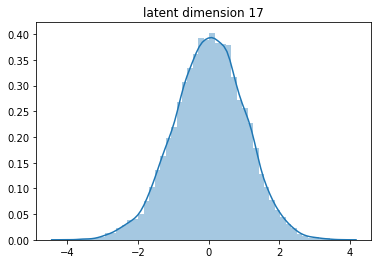

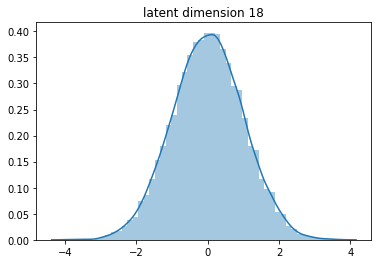

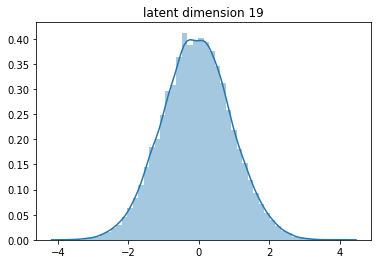

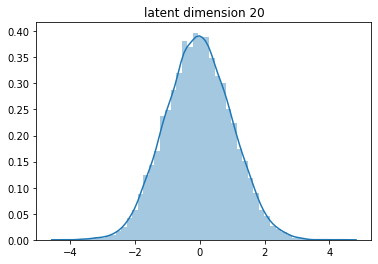

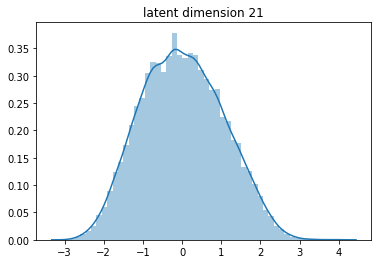

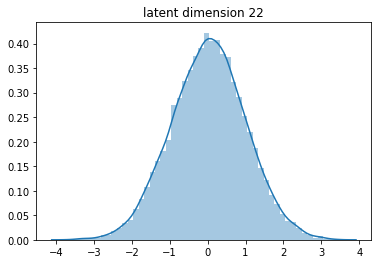

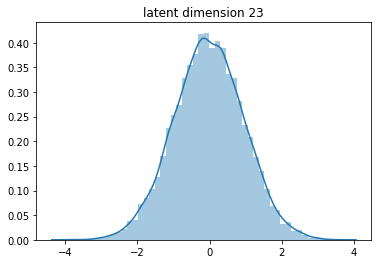

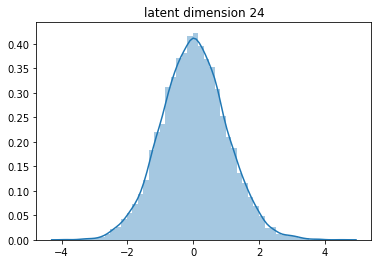

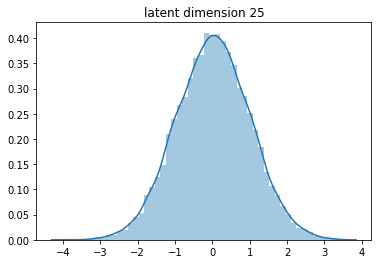

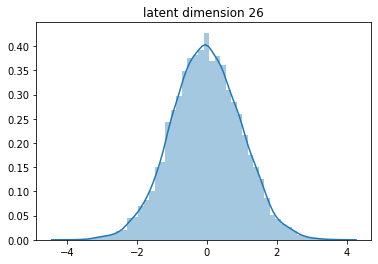

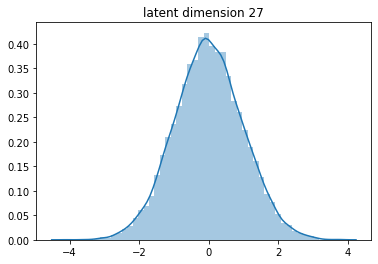

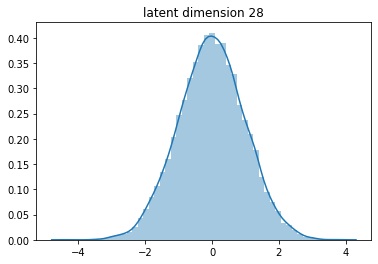

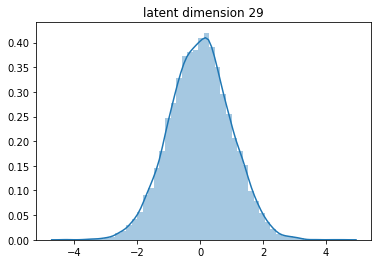

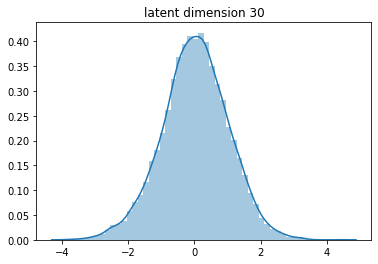

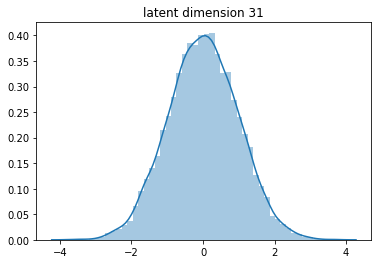

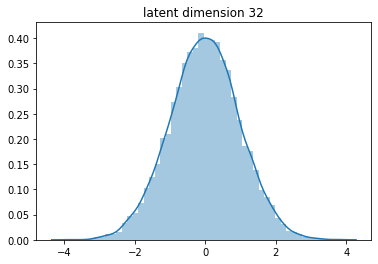

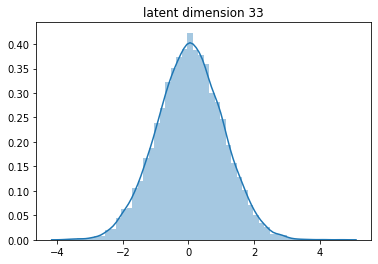

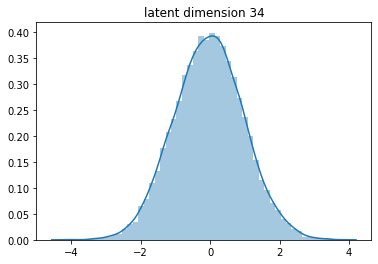

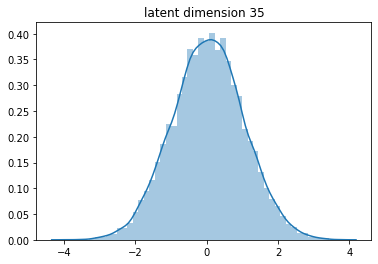

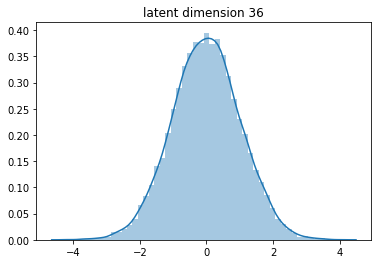

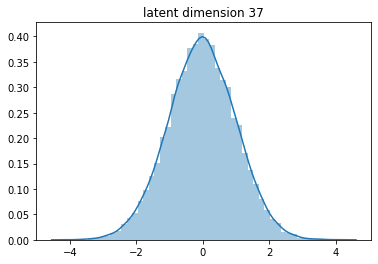

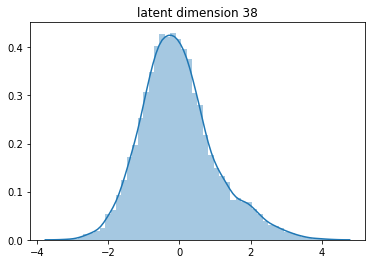

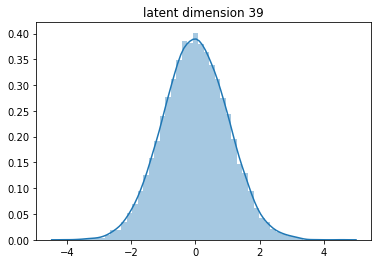

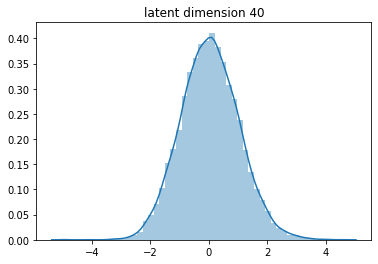

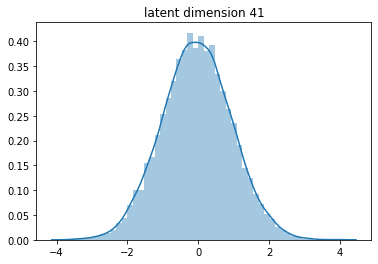

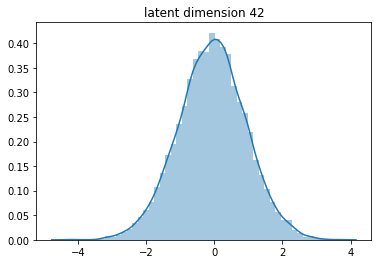

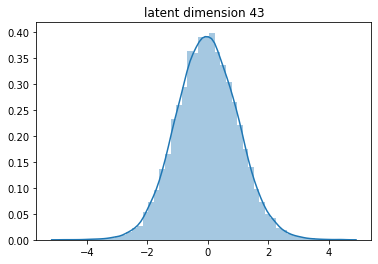

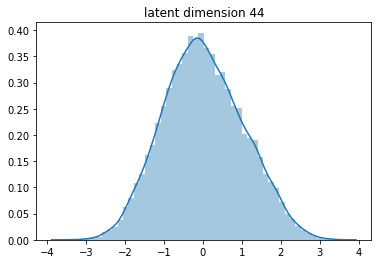

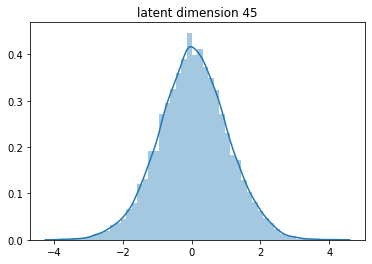

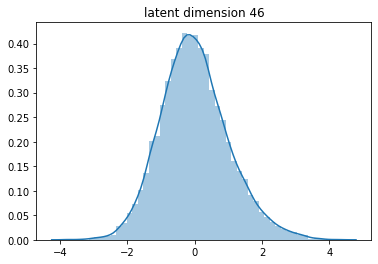

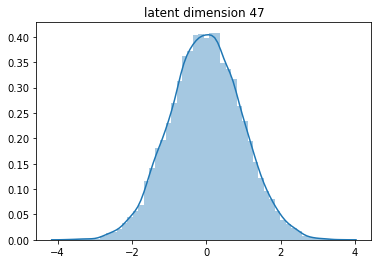

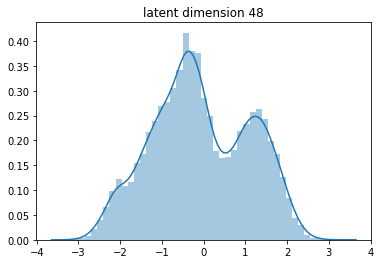

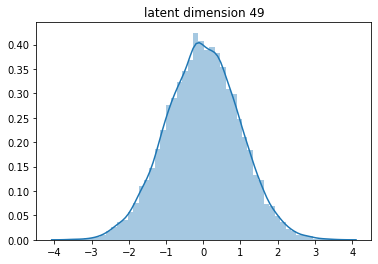

In [7]:
codings, *_ = model50.encoder(x_val)

for i in range(50):
    plt.title(f"latent dimension {i}")
    sns.distplot(codings[:, i])
    plt.show()